# Extrapolate bias-corrected TF from EN4 grid to ISMIP
Based on Donald's code for extrapolating ocean properties.  Accounts for effective depth using lookup table.

21 Jul 2025 | EHU
- 24 Jul: Attempt with xarray functionality, as NetCDF complaining about shape of grid.  Tried to convert coords on a single slice, but this did not work.  Try making meshgrid?  Or try CESM test case instead of EN4?
- 25 Jul: Meshgrid worked for EN4.  Adapted for use with CESM2-WACCM test file, which already has 2D lat/lon, and this worked well with original pyproj functionality.  Confirmed that mapped values at least look like Greenland area.
- 28 Jul: fixed later part of code that maps to ISMIP grid. Dimensions were out of order.
- 30 Jul: apply in full process of CESM2-WACCM data, 1850-2014.  Use output of Step2 notebook (QDM corrected)
- 31 Jul: apply to additional QDM-corrected CESM2-WACCM output, 1985-2100.
- 19 Sept: apply to common-gridded QDM output, 1850-2100.

In [2]:
# libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from netCDF4 import Dataset
import os
from pyproj import Transformer
from scipy.interpolate import interp1d


In [3]:
## load effective geometry (spatial look-up table)

# files
xy_eff_file = '/Users/eultee/Library/CloudStorage/OneDrive-NASA/Documents/ISMIP7/Slater-extrapolate/XY_eff.nc'
z_eff_file = '/Users/eultee/Library/CloudStorage/OneDrive-NASA/Documents/ISMIP7/Slater-extrapolate/z_eff.nc'

# effective geometry
# NB replace masked values with NaNs
X_eff = nc.Dataset(xy_eff_file).variables['X_eff'][:].filled(np.nan)
Y_eff = nc.Dataset(xy_eff_file).variables['Y_eff'][:].filled(np.nan)
z_eff = nc.Dataset(z_eff_file).variables['z_eff'][:].filled(np.nan)

# ismip coordinates at which effective geometry applies
x = nc.Dataset(xy_eff_file).variables['x'][:].filled(np.nan)
y = nc.Dataset(xy_eff_file).variables['y'][:].filled(np.nan)
X, Y = np.meshgrid(x, y)

# vertical grid of effective depths
z = np.flipud(np.unique(z_eff[z_eff<=0]))


Load CESM2 data to test the workflow.  Unlike Donald's original workflow, we are loading in pre-computed TF rather than ocean properties.

Note 22 Jul: Donald's workflow using NetCDF and pyproj had an error saying the size of the lat, lon, time dimensions were inconsistent.  Try with `rioxarray` instead, since this is already in the workflow.

25 Jul: `rioxarray` option not helpful here, but leaving this dataset read-in because it's helpful to orient.

In [4]:
## load and process data
import xarray
# import rioxarray
# import rasterio

## files
SelModel = 'CESM2-WACCM' ## model label for input and output
PressureAlreadyIncluded = True ## was the pressure effect accounted for in Step 1?
YearTags = ['1985', '2101']

DirSave = f'/Users/eultee/Desktop/'

model_path = DirSave
# if PressureAlreadyIncluded:
#     model_path = model_path + 'Default_FullProcess/'
#     model_file = model_path + 'tfQDM-AllLevels-{}-{}_{}-IncludingPressure-20250731.nc'.format(SelModel, YearTags[0], YearTags[1])
# else:
#     model_path = model_path + 'FP_in_Step3/'
#     model_file = model_path + 'tfQDM-AllLevels-{}-1850_2014-NoPressure-2025-07-30.nc'.format(SelModel)

model_file = DirSave + 'tfQDM_additive-AllLevels-CommonGrid-CESM2-WACCM-1850_2100-IncludingPressure-20250919.nc'

ds_model = xr.open_dataset(model_file, decode_times='timeDim')

# ds_slice = ds_en4.sel(depth=500, method='nearest')

# WGS84 = rasterio.crs.CRS.from_epsg(4326)
# ds_slice.rio.write_crs(WGS84, inplace=True).rio.set_spatial_dims(
#     x_dim='lon',
#     y_dim='lat',
#     inplace=True,
# ).rio.write_coordinate_system(inplace=True)

# ds_slice

In [5]:
ds_model

<xarray.Dataset> Size: 3GB
Dimensions:  (depth: 41, y: 73, x: 43, time: 3001)
Coordinates:
  * depth    (depth) float32 164B 0.0 50.0 100.0 ... 1.9e+03 1.95e+03 2e+03
  * y        (y) float32 292B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
  * x        (x) float32 172B -7.2e+05 -6.8e+05 -6.4e+05 ... 9.2e+05 9.6e+05
  * time     (time) datetime64[ns] 24kB 1850-12-31 1851-01-31 ... 2100-12-31
    lat      (y, x) float32 13kB ...
    lon      (y, x) float32 13kB ...
Data variables:
    TF       (depth, y, x, time) float64 3GB ...
Attributes:
    title:          QDM-corrected ocean thermal forcing for CESM2-WACCM
    summary:        TF computed following Verjans code, in a bounding box aro...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-09-19 15:31:10

In [6]:
ds_model.sel(depth=500, method='nearest').max()

<xarray.Dataset> Size: 12B
Dimensions:  ()
Coordinates:
    depth    float32 4B 500.0
Data variables:
    TF       float64 8B 11.32

In [25]:
## load and process data

# cmip model coordinates
lat_model = nc.Dataset(model_file).variables['lat'][:].filled(np.nan)
lon_model_raw = nc.Dataset(model_file).variables['lon'][:].filled(np.nan)
z_model = (nc.Dataset(model_file).variables['depth'][:].filled(np.nan)) ## QDM processed file should have depth in m
t_model = nc.Dataset(model_file).variables['time'][:].filled(np.nan)

## Common grid has y, x in EPSG 3413 already
x_model = nc.Dataset(model_file).variables['x'][:].filled(np.nan)
y_model = nc.Dataset(model_file).variables['y'][:].filled(np.nan)

# lon_model = np.mod((lon_model_raw+180), 360) -180 ## put back on -180 to 180 axis
# lon_model = lon_model_raw
# lon_grid, lat_grid = np.meshgrid(lon_model, lat_model) ## necessary if 1D arrays


# # get coordinates in EPSG:3413 for consistency with ismip grid
# mapping = Transformer.from_crs("epsg:4326", "epsg:3413", always_xy=True)
# x_model, y_model = mapping.transform(lon_model, lat_model)

# ## load TF
TF_model_raw = nc.Dataset(model_file).variables['TF'][:]
TF_model_nonneg = np.ma.masked_less(TF_model_raw, 0) ## filter out erroneous negative values
# TF_model_pos = np.ma.filled(TF_model_nonneg, fill_value=0) ## and assign 0
TF_model = np.ma.masked_greater(TF_model_nonneg, 1.1e10) ## filter out fill value

In [26]:
np.max(TF_model)

np.float64(17.850167512893677)

In [27]:
np.min(TF_model)

np.float64(1.461693521775942e-07)

In [28]:
TF_model

masked_array(
  data=[[[[--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          ...,
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --]],

         [[--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [2.2139752809862836, 3.2402928774218305, 5.06891951011226,
           ..., 10.025322437286377, 8.117272853851318,
           6.612515926361084],
          ...,
          [8.220513230021812, 7.956102257426597, 7.6428583914598, ...,
           11.730466069142087, 10.227545918385252, 8.810826486393577],
          [8.483967449374447, 8.220214512057552, 7.904565479464779,
           ..., 11.930355026186312, 10.448922111452426,
           9.080207510982454],
          [--, --, --, ..., --, --, --]],

         [[--, --, --, ..., --, --, --],
          [2.0273623835802796, 2.9826794039965394, 5.103010214543414,
           ..., 10.0

In [32]:
## we can tell from the read-in above that TF_model from EN4 has dimensions (depth, lat, lon, time)
## change to ## depth, time, lat, lon as the code is expecting

## for CESM2-WACCM raw, it is (time, depth, lat, lon)
## for CESM2-WACCM QDM-corrected, it is (depth, nlat, nlon, time)

## pre-gridded output should already be cropped and on effective depth grid?
## commenting all below here 19 Sept
## ---
# # crop CMIP output to area of interest around Greenland
# xlims = [np.min(x), np.max(x)]
# ylims = [np.min(y), np.max(y)]
# x_model = x_model.flatten()
# y_model = y_model.flatten()
# inds = np.where((x_model > xlims[0]) & (x_model < xlims[1]) & (y_model > ylims[0]) & (y_model < ylims[1]))[0]
# x_model = x_model[inds]
# y_model = y_model[inds]

# ## make a filled version of the masked array for interpolation and shuffling
# TF_mod_filled = np.ma.filled(TF_model, fill_value=np.nan) ## filter out fill value
# TF_shuffled = np.transpose(TF_mod_filled, axes=[0, 3, 1, 2])
# TF_nop_model_orig_crop = TF_shuffled.reshape(TF_shuffled.shape[0], ## depth
#                                           TF_shuffled.shape[1], ## time?
#                                           TF_shuffled.shape[2]*TF_shuffled.shape[3])[:,:,inds] ## should be x*y
# TF_nop_model_orig_crop = np.ma.masked_greater(TF_nop_model_orig_crop, 1.1e10)

# # interpolate the thermal forcing from cmip vertical grid onto the effective depth grid
# interp_TF = interp1d(z_model, TF_nop_model_orig_crop, axis=0, bounds_error=False, fill_value='extrapolate')
# ## note which axis is depth/z. Donald's default had axis=1, but checking the shape of TF_model 
# ## showed that it had depth as its zeroth axis. Consistent with TF_shuffled order above

# ## make z increase downwards -- consistent with CESM2-WACCM convention
# z_inc_down = -1*z
# TF_nop_model = interp_TF(z_inc_down)
## ---

# get max depth at which each cmip point has a thermal forcing value
depth_model = np.full(x_model.shape, np.nan)
for i in range(len(x_model)):
    tf = TF_model[:,0,i] ## careful with order of axes here
    if np.all(np.isnan(tf)):
        continue
    elif np.all(~np.isnan(tf)):
        depth_model[i] = z[-1]
    else:
        first_nan = np.argmax(np.isnan(tf))
        depth_model[i] = z[first_nan-1]
        

In [31]:
z_model

array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1050., 1100., 1150., 1200., 1250., 1300.,
       1350., 1400., 1450., 1500., 1550., 1600., 1650., 1700., 1750.,
       1800., 1850., 1900., 1950., 2000.], dtype=float32)

In [33]:
depth_model

array([-2000., -2000., -2000., -2000., -2000., -2000., -2000., -2000.,
       -2000., -2000., -2000., -2000., -2000., -2000., -2000., -2000.,
       -2000., -2000., -2000., -2000., -2000., -2000., -2000., -2000.,
       -2000., -2000., -2000., -2000., -2000., -2000., -2000., -2000.,
       -2000., -2000., -2000., -2000., -2000., -2000., -2000., -2000.,
       -2000., -2000., -2000.])

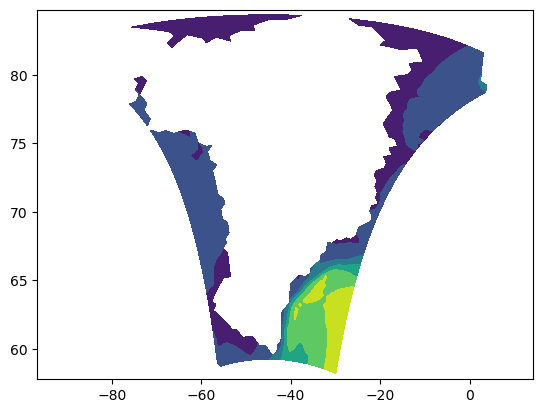

ValueError: 'c' argument has 3011 elements, which is inconsistent with 'x' and 'y' with size 3139.

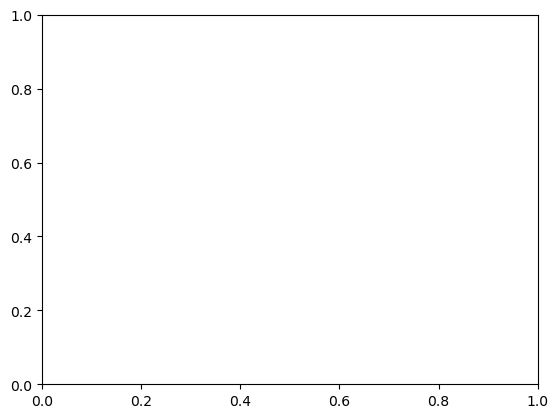

In [35]:
## plots to check things make sense

xm, ym = np.meshgrid(x_model, y_model)

fig, ax = plt.subplots()
# ax.contourf(lon_model, lat_model, TF_model[0,0, :,:]) ## for raw
ax.contourf(lon_model, lat_model, TF_model[0,:,:,0]) ## for QDM-processed
plt.show()

plt.scatter(xm, ym, c=TF_nop_model[0,0,:])
plt.colorbar(label='thermal forcing at first time and depth slice (°C)')
plt.axis('equal')
plt.show()

plt.scatter(x_model, y_model, c=depth_model)
plt.colorbar(label='max depth of non-NaN data in CMIP model (m)')
plt.axis('equal')
plt.show()


In [36]:
z_eff

array([[-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       [-2000., -2000., -2000., ..., -2000., -2000., -2000.],
       ...,
       [ -200.,  -200.,  -200., ...,    nan,    nan,    nan],
       [ -200.,  -200.,  -200., ...,    nan,    nan,    nan],
       [ -200.,  -200.,  -200., ...,    nan,    nan,    nan]],
      shape=(2881, 1681), dtype=float32)

In [37]:
## match ismip points to cmip points

# linear versions of effective position arrays
X_eff_flat = X_eff.flatten()
Y_eff_flat = Y_eff.flatten()

# initialise arrays that will store the linear index of the required cmip point
x_ind = np.full_like(X_eff_flat, np.nan, dtype=float)
z_ind = np.full_like(X_eff_flat, np.nan, dtype=float)

# loop over effective depth grid
for k, z_val in enumerate(z):
    
    # get all ismip points with this effective depth
    i_inds = np.where(z_eff.flatten() == z_val)[0]

    # save the effective depth index
    z_ind[i_inds] = k

    # get all cmip points that have data at this depth
    c_inds = np.where(depth_model.flatten() <= z_val)[0]

    # loop over ismip points with this effective depth and find closest cmip point to effective position
    for i in i_inds:
        dsq = (x_model[c_inds] - X_eff_flat[i])**2 + (y_model[c_inds] - Y_eff_flat[i])**2
        id_min = np.argmin(dsq)
        x_ind[i] = c_inds[id_min]
    

In [38]:
## now we fill the ismip TF using the matched cmip positions and depths

# initialise array
TF_nop = np.full((len(t_model), len(x_ind)), np.nan)

# fill array knowing that the ismip TF(t,i) equals the cmip TF(t,z_ind(i),x_ind(i))
for i in range(len(x_ind)):
    if not np.isnan(x_ind[i]):
        # TF_nop[:, i] = TF_nop_model[:, int(z_ind[i]), int(x_ind[i])]
        ## we ordered differently above in TF_nop_model -- depth first
        TF_nop[:,i] = TF_nop_model[int(z_ind[i]), :, int(x_ind[i])]

# reshape array for consistency with ismip coordinates
TF_nop = TF_nop.reshape(len(t_model), X.shape[0], X.shape[1])


In [39]:
## final corrections

## Freezing point dependence on pressure already included Step 1 computation
if PressureAlreadyIncluded:
    TF = TF_nop
else:
    ## correct for the freezing point dependence on pressure
    TF = np.full_like(TF_nop, np.nan, dtype=float)
    l3 = 7.61e-4; # dependence of freezing point on depth
    for k in range(TF_nop.shape[0]):
        TF[k, :, :] = TF_nop[k, :, :] - l3 * z_eff
 

In [40]:
# # check if any TF are less than 0 and fix
# TF = np.full_like(TF_nop, np.nan, dtype=float) ## no pressure correction
inds = np.where(TF < 0)
num_corrected = len(inds[0])
if num_corrected > 0:
    TF[inds] = 0
    print(f"Warning: {num_corrected} pixels corrected for TF<0")

# all the unconnected below sea level points must be assigned TF=0 -  these points have z_eff=NaN
TF[:, np.isnan(z_eff)] = 0

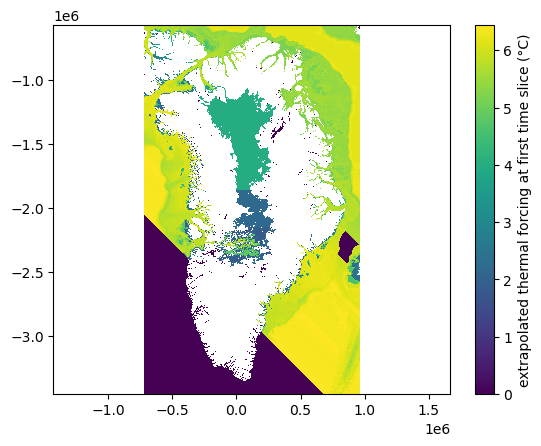

In [41]:
## plot an example of the result

plt.pcolormesh(X, Y, TF[0, :, :])
cbar = plt.colorbar()
cbar.set_label('extrapolated thermal forcing at first time slice (°C)')
plt.axis('equal')
plt.show()

In [ ]:
t_model

In [ ]:
# ## write to output file
# from datetime import date

# if PressureAlreadyIncluded:
#     p_tag = 'PFromStep1'
# else:
#     p_tag = 'PCorrected_Step3'

# # file name
# output_file = 'TF-{}-ISMIP_Grid-{}-QDM_corrected-{}.nc'.format(SelModel, p_tag, date.today())

# # delete previous file if it exists
# if os.path.exists(output_file):
#     os.remove(output_file)

# # write netcdf
# with Dataset(output_file, 'w', format='NETCDF4') as nc:

#     # dimensions
#     nc.createDimension('x', len(x))
#     nc.createDimension('y', len(y))
#     nc.createDimension('t', len(t_model))

#     # variables
#     x_var = nc.createVariable('x', np.float32, ('x',))  # 'f4' = single precision float
#     y_var = nc.createVariable('y', np.float32, ('y',))
#     t_var = nc.createVariable('t', np.float32, ('t',))
#     TF_var = nc.createVariable('TF', np.float32, ('t', 'y', 'x'), zlib=True, complevel=9)

#     # Write data
#     x_var[:] = np.array(x, dtype=np.float32)
#     y_var[:] = np.array(y, dtype=np.float32)
#     t_var[:] = np.array(t_model, dtype=np.float32)
#     TF_var[:, :, :] = np.array(TF, dtype=np.float32)


## Write out
Use xarray to write nice metadata and keep date format intact.

In [ ]:
TF_out_ds = xr.Dataset(
    data_vars = dict(TF=(['time', 'y', 'x'], TF)), 
    coords = dict(
        time = ds_model.time, ## cheat a bit and take the datetime64 index from ds_model, read in above
        y = y,
        x = x)
)

TF_out_ds

Explicitly set some metadata, and specify that TF should be written as float32 (like Donald did in his approach).

In [ ]:
TF_out_ds.coords['y'].attrs['units'] = 'meters'
TF_out_ds.coords['y'].attrs['projection'] = 'EPSG:3413'
TF_out_ds.coords['x'].attrs['units'] = 'meters'
TF_out_ds.coords['x'].attrs['projection'] = 'EPSG:3413'

TF_out_ds.TF.attrs['long_name'] = 'Ocean thermal forcing'
TF_out_ds.TF.attrs['fill_value'] = 1.1e20 ## confirm we are actually filling rather than leaving nan
TF_out_ds

In [ ]:
TF_reduced = TF_out_ds.astype('float32')
TF_reduced

In [ ]:
## write to output file
from datetime import datetime

now = datetime.now()

## Make filename tags showing time for the output 
## this is very janky, but datetime64 objects are stubborn
FirstYear = TF_reduced.time[0].values.astype(str).split('-')[0] 
LastYear = TF_reduced.time[-1].values.astype(str).split('-')[0]

if PressureAlreadyIncluded:
    p_tag = 'PFromStep1'
else:
    p_tag = 'PCorrected_Step3'

## file name
out_fn = DirSave + 'TF_aQDM-ISMIP_Grid-{}-{}_{}-{}-{}.nc'.format(SelModel, 
                                                    FirstYear, LastYear, 
                                                    p_tag, 
                                                    now.strftime('%Y%m%d'))

# ds_temp = tf_out.to_dataset(name='TF')
ds_out = TF_reduced.assign_attrs(title='QDM-corrected ocean thermal forcing for {}'.format(SelModel),
                             summary='TF computed following Verjans bias correction and Slater inland mapping,' + 
                             'in a bounding box around Greenland, for ISMIP7 Greenland forcing.' +
                                ' Additive QDM correction based on EN4, 1985-2014.' +
                                ' Process code: github.com/ehultee/gris-iceocean-process',
                             institution='NASA Goddard Space Flight Center',
                             creation_date=now.strftime('%Y-%m-%d %H:%M:%S'))

## write it!
ds_out.to_netcdf(path=out_fn,
                encoding={'TF': {'zlib': True, 'complevel':9}}) ## set compression level